# Adjusted MVRV

#### What is MVRV?
MVRV is calculated by dividing market value by realised value. In realised value, BTC prices are taken at the time they last moved, instead of the current price like in market value.

#### Problems with MVRV
The peaks and bottoms of the MVRV ratio do not peak at the same level each cycle. The signal of this indicator is decreasing.

#### Adjusted MVRV
The decay of the peaks and bottoms appear roughly linear, so a quantile linear regression can be used to find support and resistance lines to normalize the MVRV ratio.

In [1]:
import requests
import pandas as pd
import numpy as np
import json as js
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.api import OLS, QuantReg, add_constant
import scipy.stats as stats

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

## Fetch data
### 1. Fetch BTC price

In [2]:
chrome_options = Options()
chrome_options.add_argument("--headless")

driver = webdriver.Chrome(options=chrome_options)

driver.get("https://studio.glassnode.com/metrics?a=BTC&m=blockchain.BlockCount")

# BTC
driver.get("https://api.glassnode.com/v1/metrics/market/price_usd_close?a=BTC&i=24h&referrer=charts")
btc_element = driver.find_element(By.TAG_NAME, "pre")
btc = btc_element.text

driver.quit()

btc_json = js.loads(btc)

btc = pd.DataFrame(btc_json)
btc['t'] = pd.to_datetime(btc['t'], unit='s')

btc.columns = ['Date', 'Price']
btc['Date'] = pd.to_datetime(btc['Date'])
btc

,Date,Price
0,2010-07-17,0.049510
1,2010-07-18,0.085840
2,2010-07-19,0.080800
3,2010-07-20,0.074733
4,2010-07-21,0.079210
...,...,...
5166,2024-09-07,54174.601216
5167,2024-09-08,54796.311071
5168,2024-09-09,57106.048847
5169,2024-09-10,57626.382941


### 2. Fetch raw MVRV

In [3]:
# Get data for the last 4 years
response_4y = requests.get("https://api.blockchain.info/charts/mvrv?timespan=4y&sampled=true&metadata=false&daysAverageString=1d&cors=true&format=json")
json_4y = response_4y.json()
data_4y = json_4y['values']

# Get data for all time
response_all = requests.get("https://api.blockchain.info/charts/mvrv?timespan=all&sampled=true&metadata=false&daysAverageString=1d&cors=true&format=json")
json_all = response_all.json()
data_all = json_all['values']

# Combine 
four_years_ago = datetime.now() - timedelta(days=4*365)
df_4y = pd.DataFrame(data_4y)
df_all = pd.DataFrame(data_all)

df_4y.columns = ['Date', 'MVRV']
df_all.columns = ['Date', 'MVRV']

df_4y['Date'] = pd.to_datetime(pd.to_datetime(df_4y['Date'], unit='s').dt.date)
df_all['Date'] = pd.to_datetime(pd.to_datetime(df_all['Date'], unit='s').dt.date)

df_recent = df_4y[df_4y['Date'] >= four_years_ago]

df_earlier = df_all[df_all['Date'] < four_years_ago]

# Combine dfs
df = pd.concat([df_earlier, df_recent])

df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

df

,MVRV
Date,
2010-10-09,6.352667
2010-10-13,6.528319
2010-10-15,5.634472
2010-10-17,5.167244
2010-10-19,4.588882
...,...
2024-09-07,1.734393
2024-09-08,1.731705
2024-09-09,1.742689


In [4]:
merged = df.merge(btc, how='inner', on='Date', suffixes=('_mvrv', '_btc'))
merged.set_index('Date', inplace=True)
merged.dropna(inplace=True)
merged = merged.iloc[20:]
merged

,MVRV,Price
Date,,
2010-11-29,3.628116,0.233050
2010-12-02,3.106813,0.255000
2010-12-04,3.269405,0.206000
2010-12-07,2.876191,0.236600
2010-12-09,2.949800,0.192105
...,...,...
2024-09-07,1.734393,54174.601216
2024-09-08,1.731705,54796.311071
2024-09-09,1.742689,57106.048847


## Display the raw data

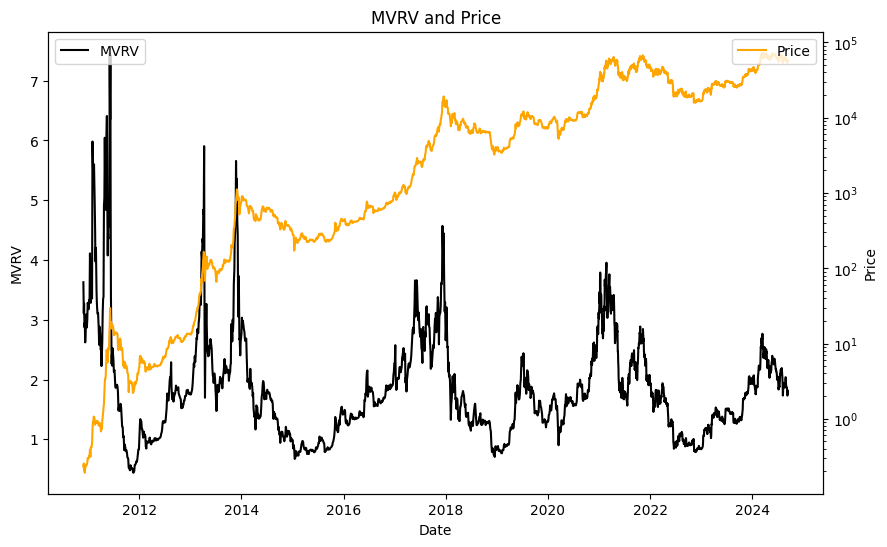

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(merged['MVRV'], label='MVRV', color='black')
ax.legend(loc='upper left')
ax.set_ylabel('MVRV')
ax.set_xlabel('Date')

ax2 = ax.twinx()
ax2.plot(merged['Price'], label='Price', color='orange')
ax2.set_yscale('log')
ax2.set_ylabel('Price')
ax2.legend(loc='upper right')

plt.title('MVRV and Price')
plt.show()

## Fit Quantile Linear Regression

### 1. Top Regression

In [6]:
t0 = merged.index.min()
X = (merged.index - t0).days.values

y = merged['MVRV'].values.reshape(-1, 1)

X_with_const = add_constant(X)

top = QuantReg(y, X_with_const)
res_top = top.fit(q=0.99)

print(res_top.summary())

                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.3891
Model:                       QuantReg   Bandwidth:                      0.3461
Method:                 Least Squares   Sparsity:                        15.24
Date:                Thu, 12 Sep 2024   No. Observations:                 2564
Time:                        17:20:55   Df Residuals:                     2562
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5014      0.073     89.523      0.000       6.359       6.644
x1            -0.0008   1.99e-05    -38.891      0.000      -0.001      -0.001

The condition number is large, 8.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


### 2. Bottom Regression


In [7]:
bottom = QuantReg(y, X_with_const)
res_bottom = bottom.fit(q=0.005)

print(res_bottom.summary())

                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.1455
Model:                       QuantReg   Bandwidth:                      0.3692
Method:                 Least Squares   Sparsity:                        4.369
Date:                Thu, 12 Sep 2024   No. Observations:                 2564
Time:                        17:20:55   Df Residuals:                     2562
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4558      0.019     24.061      0.000       0.419       0.493
x1          8.116e-05   5.45e-06     14.902      0.000    7.05e-05    9.18e-05

The condition number is large, 8.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


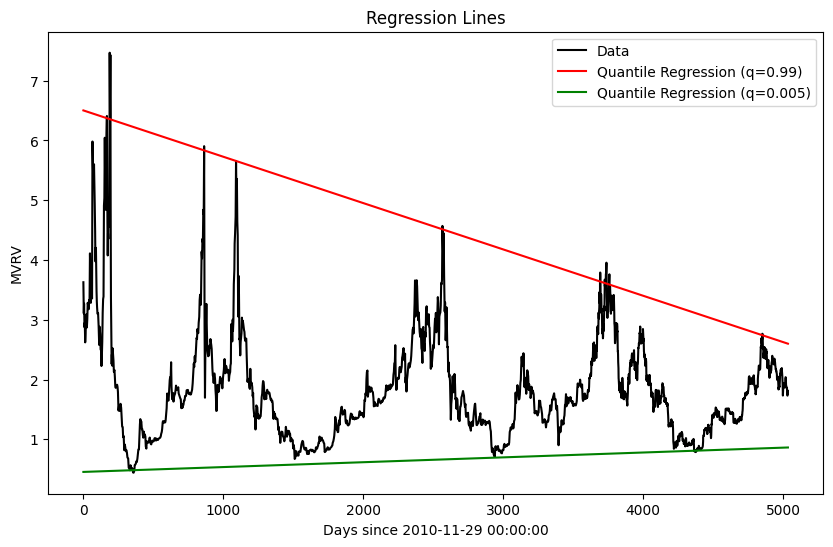

In [8]:
merged['MVRV_Top'] = res_top.predict(X_with_const)
merged['MVRV_Bottom'] = res_bottom.predict(X_with_const)

plt.figure(figsize=(10, 6))
plt.plot(X, y, label='Data', color='black')
plt.plot(X, merged['MVRV_Top'], label='Quantile Regression (q=0.99)', color='red')
plt.plot(X, merged['MVRV_Bottom'], label='Quantile Regression (q=0.005)', color='green')
plt.title('Regression Lines')
plt.xlabel('Days since ' + str(t0))
plt.ylabel('MVRV')
plt.legend()
plt.show()

## Adjusted MVRV Displays

We take a $log$ transform of the adjusted MVRV to make it more normally distributed.

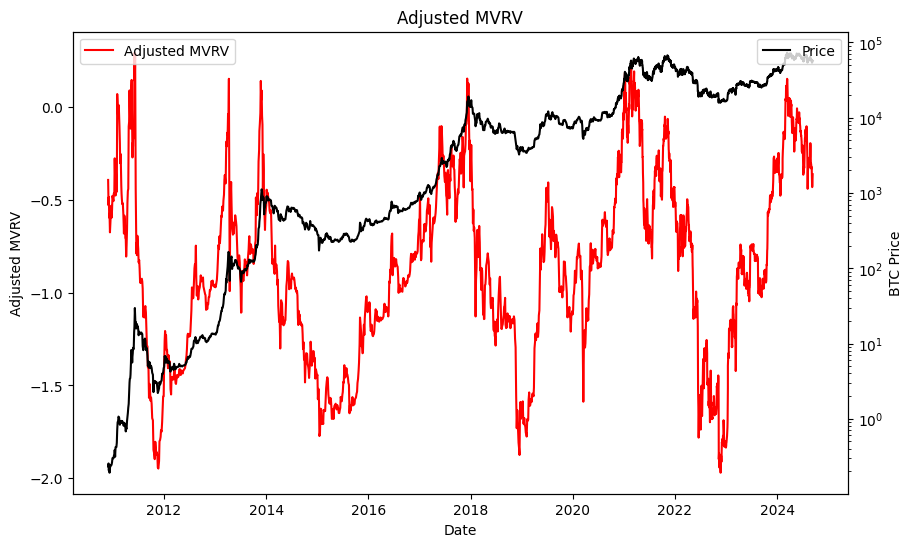

In [9]:
merged['Adjusted_MVRV'] = (merged['MVRV'] - merged['MVRV_Bottom']) / (merged['MVRV_Top'] - merged['MVRV_Bottom'])
merged['Adjusted_MVRV'] = np.log(merged['Adjusted_MVRV'] + 0.15)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(merged['Adjusted_MVRV'], color='red', label='Adjusted MVRV')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted MVRV')
ax.legend(loc='upper left')

ax2 = ax.twinx()
ax2.plot(merged['Price'], color='black', label='Price')
ax2.set_ylabel('BTC Price')
ax2.set_yscale('log')
ax2.legend(loc='upper right')

plt.title('Adjusted MVRV')
plt.show()

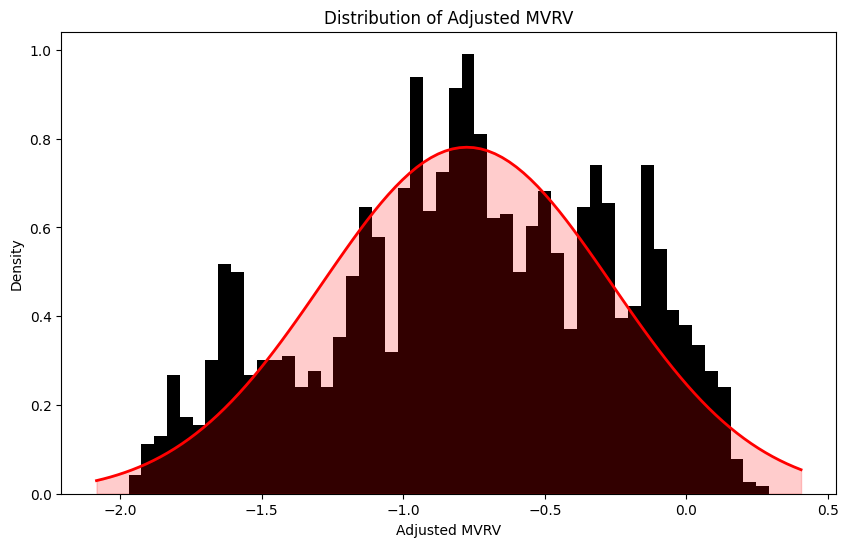

In [10]:
plt.figure(figsize=(10, 6))

# Plot hist
n, bins, patches = plt.hist(merged['Adjusted_MVRV'], bins=50, color='black', density=True)

# Get and plot normal dist
mu, std = merged['Adjusted_MVRV'].mean(), merged['Adjusted_MVRV'].std()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)

plt.plot(x, p, color='red', linewidth=2)
plt.fill_between(x, p, color='red', alpha=0.2)

plt.title('Distribution of Adjusted MVRV')
plt.xlabel('Adjusted MVRV')
plt.ylabel('Density')
plt.show()

## Conclusion

Even though the adjusted MVRV is not perfectly normally distributed, it is a much needed improvement over the raw version.

The adjusted MVRV gives a much better signal of market over/under valuation.